## Pooled model

In [1]:
#%%
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan

In [2]:
#%% The data
machines = pd.read_fwf('./ex7/factory.txt', header=None).values
machines_transposed = machines.T

In [3]:
#%% Pooled model
'''
Pooled model
'''
stan_code_pooled = '''
data {
    int<lower=0> N;       // number of data points
    vector[N] y;          //
}
parameters {
    real mu;              // group means
    real<lower=0> sigma;  // common std
}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real ypred;
    ypred = normal_rng(mu, sigma);
}
'''

In [4]:
#%% fitting data to stan model
machines_pooled = machines.flatten()
model_pooled = pystan.StanModel(model_code=stan_code_pooled)
data_pooled = dict(
    N=machines_pooled.size,
    y=machines_pooled
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e8aba0ecc735c7155fb621c1cf14928c NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmpaz7ibefd/stanfit4anon_model_e8aba0ecc735c7155fb621c1cf14928c_5643670512500397732.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
#%% sampling
fit_pooled = model_pooled.sampling(data=data_pooled)
print(fit_pooled)

Inference for Stan model: anon_model_e8aba0ecc735c7155fb621c1cf14928c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     92.87    0.06   3.35  86.22  90.65  92.87  95.06  99.41   2748    1.0
sigma  18.77    0.05   2.55   14.6  16.94   18.5  20.32  24.68   2468    1.0
ypred  93.33    0.32  19.08  55.19  80.93  93.76 105.58 130.87   3550    1.0
lp__   -99.3    0.02   0.99 -102.0 -99.66 -99.01  -98.6 -98.35   1759    1.0

Samples were drawn using NUTS at Sun Nov  4 23:39:01 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<Figure size 432x288 with 0 Axes>

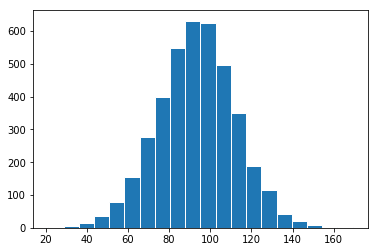

<Figure size 432x288 with 0 Axes>

In [7]:
#%% hist
y_pred_pooled = fit_pooled.extract()['ypred']
plt.hist(y_pred_pooled, bins=20, ec='white')
plt.savefig('./ex7/report/pooled_hist.png')
plt.figure(0)

<Figure size 432x288 with 0 Axes>

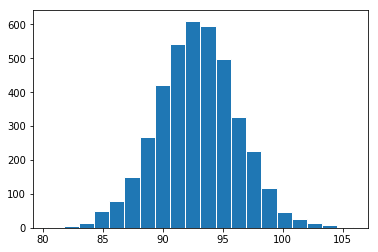

<Figure size 432x288 with 0 Axes>

In [17]:
mu = fit_pooled.extract()['mu']
plt.hist(mu, bins=20, ec='white')
plt.savefig('./ex7/report/pooled_hist_mu.png')
plt.figure(0)

# Separate model

In [8]:
stan_code_separate = '''
data {
    int<lower=0> N;               // number of data points
    int<lower=0> K;               // number of groups
    int<lower=1,upper=K> x[N];    // group indicator
    vector[N] y;
}
parameters {
    vector[K] mu;                 // group means
    vector<lower=0>[K] sigma;     // group stds
}
model {
    y ~ normal(mu[x], sigma[x]);
}
generated quantities {
    real ypred;
    ypred = normal_rng(mu[6], sigma[6]);
}
'''

In [9]:
#%% fitting data into the stan model
model_seperate = pystan.StanModel(model_code=stan_code_separate)
data_separate = dict(
    N=machines_transposed.size,
    K=6,
    x=[
        1, 1, 1, 1, 1,
        2, 2, 2, 2, 2,
        3, 3, 3, 3, 3,
        4, 4, 4, 4, 4,
        5, 5, 5, 5, 5,
        6, 6, 6, 6, 6,
    ],
    y=machines_transposed.flatten()
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_32b281d392710cf284050e850f25ceeb NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmp04o3psp3/stanfit4anon_model_32b281d392710cf284050e850f25ceeb_1038956128401493059.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
#%% sampling
fit_separate = model_seperate.sampling(data=data_separate, n_jobs=-1)
print(fit_separate)


Inference for Stan model: anon_model_32b281d392710cf284050e850f25ceeb.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     75.93    0.36   15.3   44.6  68.25  75.98  83.95 106.05   1833    1.0
mu[2]    106.57    0.34  10.33  88.75 101.66  106.3 110.89 126.97    944    1.0
mu[3]      87.8    0.23   9.49  67.93  83.03  87.92  92.65 106.74   1646    1.0
mu[4]    111.56    0.17   5.91  99.43  108.6 111.52 114.46 123.49   1225    1.0
mu[5]     89.91    0.27   9.27   70.6  85.84   90.0  94.32 107.29   1143    1.0
mu[6]     86.45    0.37  14.33  58.26  78.54  86.19   93.8 117.74   1477    1.0
sigma[1]  30.62    0.55  20.17  13.08  19.47  25.44  34.81  79.54   1352    1.0
sigma[2]  18.56    0.37  11.89   7.69  11.64  15.26  21.23  52.47   1017    1.0
sigma[3]  19.64    0.31  12.34   8.41  12.64  16.55  22.55  49.52   1574    1.0
sigma[4]  1

<Figure size 432x288 with 0 Axes>

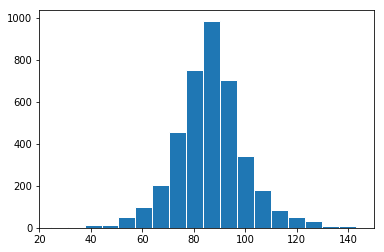

<Figure size 432x288 with 0 Axes>

In [88]:
#%% hist
mu_data_separate = fit_separate.extract()['mu']
plt.xlim(20, 150)
plt.hist(mu_data_separate[:, 5], bins=30, ec='white')
plt.savefig('./ex7/report/separate_hist_mu_six.png')
plt.figure(0)

<Figure size 432x288 with 0 Axes>

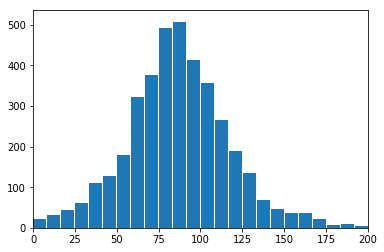

<Figure size 432x288 with 0 Axes>

In [84]:
#%% hist
y_pred_separate = fit_separate.extract()['ypred']
plt.xlim(0, 200)
plt.hist(y_pred_separate, bins=70, ec='white')
plt.savefig('./ex7/report/separate_hist.png')
plt.figure(0)

## Hierarchical model

In [44]:
stan_code_hierarchical = '''
data {
    int<lower=0> N;             // number of data points
    int<lower=0> K;             // number of groups
    int<lower=1,upper=K> x[N];  // group indicator
    vector[N] y;
}
parameters {
    real mu0;                   // prior mean
    real<lower=0> sigma0;       // prior std
    vector[K] mu;               // group means
    real<lower=0> sigma;        // common std
}
model {
    mu ~ normal(mu0, sigma0);
    y ~ normal(mu[x], sigma);
}
generated quantities {
    real ypred6;
    real mu7;
    ypred6 = normal_rng(mu[6], sigma);
    mu7 = normal_rng(mu0, sigma0);
}
'''

In [45]:
#%% fitting data into the stan model
model_hierarchical = pystan.StanModel(model_code=stan_code_hierarchical)
data_hierarchical = dict(
    N=machines_transposed.size,
    K=6,
    x=[
        1, 1, 1, 1, 1,
        2, 2, 2, 2, 2,
        3, 3, 3, 3, 3,
        4, 4, 4, 4, 4,
        5, 5, 5, 5, 5,
        6, 6, 6, 6, 6,
    ],
    y=machines_transposed.flatten()
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_568b7ff89097548a60e623f8ba374874 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmpelp0d6gh/stanfit4anon_model_568b7ff89097548a60e623f8ba374874_4402916374249434465.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [46]:
#%% sampling
fit_hierarchical = model_hierarchical.sampling(data=data_hierarchical, n_jobs=-1)
print(fit_hierarchical)

Inference for Stan model: anon_model_568b7ff89097548a60e623f8ba374874.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu0     92.13    0.36   9.72   71.8  88.13  92.64  97.03 108.53    738    1.0
sigma0  17.08    0.46  12.29   5.38  10.49  14.32  20.03  45.45    729   1.01
mu[1]   79.71    0.15   6.56  66.76  75.32  79.65  84.13  92.72   1992    1.0
mu[2]  103.07    0.14   6.48  90.04  98.92 103.04 107.31 116.52   2247    1.0
mu[3]   88.89    0.09   6.18  76.41  84.87  88.85  92.92 101.25   4231    1.0
mu[4]  107.56    0.18   6.68  94.24 103.04 107.69 112.16 120.04   1345    1.0
mu[5]   90.47     0.1   6.12  78.28  86.59  90.45  94.46 102.45   3904    1.0
mu[6]   87.32     0.1   6.25  75.07  83.08  87.31  91.64  99.36   3647    1.0
sigma   15.18    0.06   2.27  11.55  13.55  14.91  16.54  20.41   1572    1.0
ypred6   87.0    0.26  16.89  5

<Figure size 432x288 with 0 Axes>

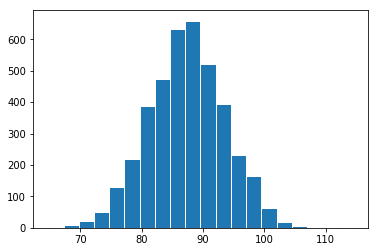

<Figure size 432x288 with 0 Axes>

In [48]:
#%% hist
mu_data_hierarchical = fit_hierarchical.extract()['mu']
plt.hist(mu_data_hierarchical[:, 5], bins=20, ec='white')
plt.savefig('./ex7/report/hierarchical_hist_mu_six.png')
plt.figure(0)

<Figure size 432x288 with 0 Axes>

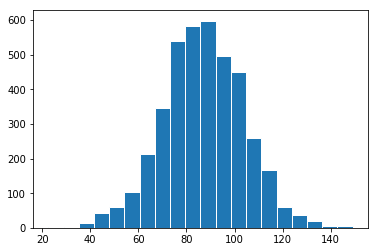

<Figure size 432x288 with 0 Axes>

In [49]:
#%% hist
y_pred_hierarchical = fit_hierarchical.extract()['ypred6']
plt.hist(y_pred_hierarchical, bins=20, ec='white')
plt.savefig('./ex7/report/hierarchical_hist.png')
plt.figure(0)

<Figure size 432x288 with 0 Axes>

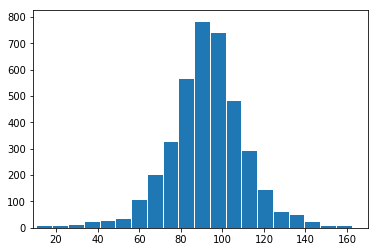

<Figure size 432x288 with 0 Axes>

In [79]:
#%% hist
mu_data_hierarchical_7 = fit_hierarchical.extract()['mu7']
plt.xlim(9, 170)
plt.hist(mu_data_hierarchical_7, bins=70, ec='white')
plt.savefig('./ex7/report/hierarchical_hist_mu_7.png')
plt.figure(0)